# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

There are 426880 cars with different models and features. We want to understand what features influence the used car price.
the goal is to predict a car's price based on various features such as make, model, mileage, year, condition, location, and other attributes.
We will analyze these car values and then give recommendation to a car dealer on what car to buy, and how much they should sell for.
We will identify significant predictors, preprocess the data to handle missing values and categorical variables, and develop a predictive model to estimate used car prices. 

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [31]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor

import seaborn as sns
import matplotlib.pyplot as plt

from joblib import parallel_backend

In [7]:
df = pd.read_csv("data/vehicles.csv", na_values=["", "NA", "?"])  # Treat empty strings and '?' as NaN
print(df.info())  # Check data types and missing values
print(df.describe())  # Summary statistics for numerical features

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [9]:
df[df['price'] < 1000]

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
10,7218893038,el paso,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tx
11,7218325704,el paso,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tx
12,7217788283,el paso,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tx
13,7217147606,el paso,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tx
14,7209027818,el paso,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tx
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426764,7303347225,wyoming,0,2018.0,NaN,peterbilt 579,NaN,NaN,diesel,1.0,clean,automatic,NaN,NaN,NaN,NaN,NaN,wy
426812,7302877815,wyoming,0,2006.0,toyota,scion tc,excellent,4 cylinders,gas,195000.0,clean,automatic,JTKDE177460109655,fwd,NaN,NaN,silver,wy
426832,7302353283,wyoming,0,2004.0,toyota,prius,excellent,4 cylinders,hybrid,239000.0,clean,automatic,JTDKB20U840108051,fwd,NaN,NaN,blue,wy
426836,7302301268,wyoming,0,2018.0,ram,2500,excellent,6 cylinders,diesel,20492.0,clean,automatic,3C6UR5HL3JG307217,4wd,full-size,truck,white,wy


### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [14]:
## drop columns are not important to car values.
df.drop(columns=["id", "VIN"], inplace=True)

## drop state column because it is strongly correlated to the other column region. The region column gave better accuracy.
df.drop(columns=["state"], inplace=True)

# Drop columns with too many missing values (e.g., more than 30%)
threshold = 0.3  # 30% missing values threshold
df = df.dropna(thresh=len(df) * threshold, axis=1)

# Drop rows if price < 1000
df = df[df['price'] >= 1000]

df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 380565 entries, 0 to 426879
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   region        380565 non-null  object 
 1   price         380565 non-null  int64  
 2   year          379400 non-null  float64
 3   manufacturer  365403 non-null  object 
 4   model         376084 non-null  object 
 5   condition     237116 non-null  object 
 6   cylinders     225263 non-null  object 
 7   fuel          377973 non-null  object 
 8   odometer      378486 non-null  float64
 9   title_status  374006 non-null  object 
 10  transmission  378748 non-null  object 
 11  drive         265286 non-null  object 
 12  type          299319 non-null  object 
 13  paint_color   271698 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 43.6+ MB


In [16]:
# Fill missing categorical values with "Others"
categorical_cols = ["manufacturer", "model", "condition", "cylinders", "fuel", "title_status", "transmission", "drive", "type", "paint_color"]
df[categorical_cols] = df[categorical_cols].fillna("Others")

# Fill missing numerical values with median
df.fillna({"year": df["year"].median()}, inplace=True)
df.fillna({"odometer": df["odometer"].median()}, inplace=True)

df["year"] = df["year"].astype(int)
df["odometer"] = df["odometer"].astype(int)


df.info()
df.sample(10)

<class 'pandas.core.frame.DataFrame'>
Index: 380565 entries, 0 to 426879
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   region        380565 non-null  object
 1   price         380565 non-null  int64 
 2   year          380565 non-null  int32 
 3   manufacturer  380565 non-null  object
 4   model         380565 non-null  object
 5   condition     380565 non-null  object
 6   cylinders     380565 non-null  object
 7   fuel          380565 non-null  object
 8   odometer      380565 non-null  int32 
 9   title_status  380565 non-null  object
 10  transmission  380565 non-null  object
 11  drive         380565 non-null  object
 12  type          380565 non-null  object
 13  paint_color   380565 non-null  object
dtypes: int32(2), int64(1), object(11)
memory usage: 40.6+ MB


,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color
308246,tulsa,27500,2020,ford,edge,Others,Others,gas,28535,clean,automatic,fwd,Others,black
108889,sarasota-bradenton,26997,2017,bmw,5 series,excellent,Others,gas,56071,clean,automatic,rwd,sedan,Others
351469,sioux falls / SE SD,10550,2016,jeep,patriot,Others,4 cylinders,gas,113448,clean,automatic,4wd,SUV,custom
265481,albany,30900,2016,ford,f-150,excellent,6 cylinders,gas,80400,clean,automatic,4wd,truck,silver
79306,fort collins / north CO,23999,2020,buick,encore gx preferred,Others,3 cylinders,gas,5445,clean,automatic,4wd,SUV,Others
141966,chicago,38990,2018,cadillac,ct6 plug-in sedan 4d,good,Others,gas,19957,clean,other,rwd,sedan,white
210467,upper peninsula,7500,2006,ford,f150 super cab stx 4x4,excellent,8 cylinders,gas,138456,clean,automatic,4wd,pickup,white
135703,pullman / moscow,52999,2021,toyota,tacoma limited 4x4 gas,Others,Others,gas,6057,clean,automatic,4wd,truck,white
303794,zanesville / cambridge,8950,2010,ford,explorer,Others,Others,gas,108631,clean,automatic,4wd,other,black
285401,new hampshire,27000,2014,ram,2500 crew cab,Others,8 cylinders,gas,110000,clean,automatic,4wd,Others,Others


### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [21]:
# One-hot encode categorical features
df_encoded = pd.get_dummies(df, drop_first=True)
df_encoded.info()
df_encoded.sample()

<class 'pandas.core.frame.DataFrame'>
Index: 380565 entries, 0 to 426879
Columns: 27737 entries, price to paint_color_yellow
dtypes: bool(27734), int32(2), int64(1)
memory usage: 9.8 GB


,price,year,odometer,region_abilene,region_akron / canton,region_albany,region_albuquerque,region_altoona-johnstown,region_amarillo,region_ames,...,paint_color_brown,paint_color_custom,paint_color_green,paint_color_grey,paint_color_orange,paint_color_purple,paint_color_red,paint_color_silver,paint_color_white,paint_color_yellow
227647,37998,2017,25911,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [34]:
# Calculate correlation matrix
correlation_matrix = df_encoded.sample(100).corr()

# Display the correlation of each feature with price
price_correlation = correlation_matrix['price'].sort_values(ascending=False)
print(price_correlation)
## keep only the 100 columns for price_correlation.index.to_list()[0:100]
#### based on the correlation analysis, we will keep these columns only: year, odometer, region, state, fuel, manufacturer,model,cylinders,drive,title_status
## region and state might be bonded, will drop state column.
## surprisingly, the condition does not have impact the price much. Will drop it.
##
pd.set_option('display.max_rows', 100)
price_correlation.head(100)
##
# price                                 1.000000
# year                                  0.476922
# type_pickup                           0.402335
# region_las cruces                     0.305818
# region_bakersfield                    0.285953
# model_2500                            0.285953
# manufacturer_gmc                      0.254167
# fuel_other                            0.247081
# model_lifted sierra 1500 elevation    0.246315
# region_wenatchee                      0.246315
# transmission_other                    0.244472
# type_other                            0.234310
# condition_good                        0.196539
# model_Unknown                         0.195120
# model_titan                           0.190326
# fuel_diesel                           0.186531
# paint_color_white                     0.182546
# region_memphis                        0.180148
# manufacturer_rover                    0.180148
# model_range evoque p250 se            0.180148
# cylinders_other                       0.173933
# model_tacoma trd sport                0.173603
# region_ventura county                 0.173603
# model_sl-class sl 550                 0.166926
# title_status_clean                    0.159846
# manufacturer_jeep                     0.154973
# model_silverado 1500 ltz              0.153738
# region_joplin                         0.153738
# manufacturer_toyota                   0.153636
# model_t campervan rv                  0.147160
# region_salt lake city                 0.147160
# region_reading                        0.147094
# model_silverado 2500 hd crew          0.147094
# region_fredericksburg                 0.140483
# model_tundra double cab sr5           0.140483
# region_los angeles                    0.133939
# model_wrangler unlimited sahara       0.133939
# model_e-class                         0.133926
# region_lakeland                       0.133926
# region_merced                         0.133873
# model_tundra crewmax sr5 pickup       0.133873
# manufacturer_tesla                    0.133749
# manufacturer_ram                      0.133664
# type_convertible                      0.132496
# region_columbia / jeff city           0.131228
# model_corvette grand sport            0.131228
# paint_color_black                     0.130012
# cylinders_8 cylinders                 0.125871
# model_sedona                          0.125477
# region_hawaii                         0.125477
# region_western massachusetts          0.109994
# model_grand cherokee                  0.107463
# region_kalamazoo                      0.107463
# region_billings                       0.107463
# model_sierra                          0.107463
# model_terrain                         0.105413
# manufacturer_mercedes-benz            0.103223
# drive_Unknown                         0.101331
# cylinders_Unknown                     0.094708
# manufacturer_buick                    0.081053
# region_bemidji                        0.081053
# model_envision                        0.081053
# manufacturer_kia                      0.080959
# paint_color_custom                    0.077012
# model_wrangler rhd 1 owner            0.074409
# region_dallas / fort worth            0.074409
# region_western maryland               0.074376
# model_tacoma double cab pickup        0.074376
# region_san luis obispo                0.073781
# model_fuso box truck                  0.073781
# manufacturer_mitsubishi               0.073781
# condition_new                         0.073559
# region_toledo                         0.067765
# model_4 series 440i xdrive gran       0.067765
# region_central michigan               0.067765
# model_f150 super cab xlt pickup       0.067765
# type_Unknown                          0.064593
# model_f-250                           0.061188
# region_birmingham                     0.061154
# model_econoline cargo van             0.061154
# region_san antonio                    0.061146
# region_new hampshire                  0.058759
# manufacturer_mini                     0.054089
# region_santa fe / taos                0.053949
# model_1500 regular cab tradesman      0.045289
# model_sierra 1500                     0.041382
# model_wrx                             0.040727
# region_fayetteville                   0.040727
# model_accord ex                       0.038083
# type_van                              0.027694
# model_highlander                      0.027645
# model_mkx reserve sport               0.025456
# region_raleigh / durham / CH          0.025456
# manufacturer_lincoln                  0.025456
# paint_color_silver                    0.024982
# region_charlotte                      0.017720
# region_bozeman                        0.011842
# manufacturer_nissan                   0.005254
# region_oklahoma city                  0.002074
# region_kansas city, MO                0.001755

price                     1.000000
model_super duty f-250    0.374538
region_ocala              0.374538
region_tucson             0.354761
model_f150 raptor         0.354761
                            ...   
title_status_salvage           NaN
type_bus                       NaN
type_offroad                   NaN
paint_color_brown              NaN
paint_color_yellow             NaN
Name: price, Length: 30153, dtype: float64


price                                                                                                               1.000000
model_super duty f-250                                                                                              0.374538
region_ocala                                                                                                        0.374538
region_tucson                                                                                                       0.354761
model_f150 raptor                                                                                                   0.354761
type_pickup                                                                                                         0.348070
model_f-250 superduty lifted stx 8ft 6.7l diesel                                                                    0.285423
region_western slope                                                                                                0.285423


In [27]:
# approach 1, tried to reduce the dimenstions after get-dummies, it does not work well.
# keep_columns_list = price_correlation.index.to_list()[0:75]
# print(keep_columns_list)
# print(type(keep_columns_list))

# df_encoded = df_encoded.loc[:, keep_columns_list]
# df_encoded.info()

In [25]:
# approach 2, set the values to "Others" for these impact the price slightly. this step can be added to pipe step 1.

allowed_values = {
    "type": ["pickup", "other", "convertible", "van", "Unknown"],
    "region": [
        "las cruces", "bakersfield", "wenatchee", "memphis", "ventura county",
        "joplin", "salt lake city", "reading", "fredericksburg", "los angeles",
        "lakeland", "merced", "columbia / jeff city", "hawaii", "western massachusetts",
        "kalamazoo", "billings", "bemidji", "dallas / fort worth", "western maryland",
        "san luis obispo", "toledo", "central michigan", "birmingham", "san antonio",
        "new hampshire", "santa fe / taos", "fayetteville", "raleigh / durham / CH",
        "charlotte", "bozeman", "oklahoma city", "kansas city, MO"
    ],
    "model": [
        "2500", "lifted sierra 1500 elevation", "titan", "range evoque p250 se",
        "tacoma trd sport", "sl-class sl 550", "silverado 1500 ltz",
        "t campervan rv", "silverado 2500 hd crew", "tundra double cab sr5",
        "wrangler unlimited sahara", "e-class", "tundra crewmax sr5 pickup",
        "corvette grand sport", "sedona", "grand cherokee", "sierra", "terrain",
        "envision", "wrangler rhd 1 owner", "tacoma double cab pickup",
        "fuso box truck", "4 series 440i xdrive gran", "f150 super cab xlt pickup",
        "f-250", "econoline cargo van", "1500 regular cab tradesman",
        "sierra 1500", "wrx", "accord ex", "highlander", "mkx reserve sport",
        "Unknown"
    ],
    "manufacturer": [
        "gmc", "rover", "jeep", "toyota", "tesla", "ram", "mercedes-benz",
        "buick", "kia", "mitsubishi", "mini", "lincoln", "nissan"
    ],
    "fuel": ["other", "diesel"],
    "transmission": ["other"],
    "condition": ["good", "new"],
    "cylinders": ["other", "8 cylinders", "Unknown"],
    "title_status": ["clean"],
    "drive": ["Unknown"],
    "paint_color": ["white", "black", "custom", "silver"]
}

df_encoded=df.copy()

# Replace values that are not in the allowed list with "Others"
for col, allowed in allowed_values.items():
    if col in df_encoded.columns:  # Ensure the column exists in the dataframe
        df_encoded[col] = df_encoded[col].apply(lambda x: x if x in allowed else "Others")

df_encoded.sample(10)


,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color
419736,Others,6388,2013,Others,Others,Others,Others,Others,139176,clean,Others,Others,Others,white
173615,Others,15500,2015,Others,Others,Others,Others,Others,116140,clean,Others,Others,Others,black
381381,san antonio,23995,2019,jeep,Others,Others,Others,Others,9676,clean,Others,Others,Others,Others
394286,Others,25995,2013,Others,Others,Others,Others,Others,133189,clean,Others,Others,other,Others
388802,Others,23000,2016,Others,Others,Others,Others,Others,9700,clean,Others,Others,convertible,Others
258934,Others,4000,2008,Others,Others,new,Others,Others,128000,clean,Others,Others,Others,silver
150415,Others,34990,2020,Others,Others,good,Others,other,7720,clean,other,Others,Others,silver
42482,Others,6400,2016,Others,Others,Others,Others,Others,97500,clean,Others,Others,Others,Others
255994,Others,3600,2002,Others,Others,Others,Others,Others,166148,clean,Others,Others,Others,Others
257124,Others,3200,2008,Others,Others,good,Others,Others,180649,clean,Others,Others,Others,black


In [27]:
# One-hot encode categorical features after formated data
df_encoded2 = pd.get_dummies(df_encoded, drop_first=True)
df_encoded2.info()
df_encoded2.sample()

<class 'pandas.core.frame.DataFrame'>
Index: 380565 entries, 0 to 426879
Data columns (total 97 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   price                               380565 non-null  int64
 1   year                                380565 non-null  int32
 2   odometer                            380565 non-null  int32
 3   region_bakersfield                  380565 non-null  bool 
 4   region_bemidji                      380565 non-null  bool 
 5   region_billings                     380565 non-null  bool 
 6   region_birmingham                   380565 non-null  bool 
 7   region_bozeman                      380565 non-null  bool 
 8   region_central michigan             380565 non-null  bool 
 9   region_charlotte                    380565 non-null  bool 
 10  region_columbia / jeff city         380565 non-null  bool 
 11  region_dallas / fort worth          380565 non-null  bool

,price,year,odometer,region_bakersfield,region_bemidji,region_billings,region_birmingham,region_bozeman,region_central michigan,region_charlotte,...,title_status_clean,transmission_other,type_convertible,type_other,type_pickup,type_van,paint_color_black,paint_color_custom,paint_color_silver,paint_color_white
180649,10990,2009,102078,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,True,False


In [41]:
# Define target variable
# target_column = 'price'
# keep_columns_list = price_correlation.index.to_list()[1:10]  # Columns to keep after transformation

# Create a copy of the original DataFrame
df_processed = df.copy()

# Step 1: Replace values not in the allowed list with "Others"
allowed_values = {
    "type": ["pickup", "other", "convertible", "van", "Unknown"],
    "region": [
        "las cruces", "bakersfield", "wenatchee", "memphis", "ventura county",
        "joplin", "salt lake city", "reading", "fredericksburg", "los angeles",
        "lakeland", "merced", "columbia / jeff city", "hawaii", "western massachusetts",
        "kalamazoo", "billings", "bemidji", "dallas / fort worth", "western maryland",
        "san luis obispo", "toledo", "central michigan", "birmingham", "san antonio",
        "new hampshire", "santa fe / taos", "fayetteville", "raleigh / durham / CH",
        "charlotte", "bozeman", "oklahoma city", "kansas city, MO"
    ],
    "model": [
        "2500", "lifted sierra 1500 elevation", "titan", "range evoque p250 se",
        "tacoma trd sport", "sl-class sl 550", "silverado 1500 ltz",
        "t campervan rv", "silverado 2500 hd crew", "tundra double cab sr5",
        "wrangler unlimited sahara", "e-class", "tundra crewmax sr5 pickup",
        "corvette grand sport", "sedona", "grand cherokee", "sierra", "terrain",
        "envision", "wrangler rhd 1 owner", "tacoma double cab pickup",
        "fuso box truck", "4 series 440i xdrive gran", "f150 super cab xlt pickup",
        "f-250", "econoline cargo van", "1500 regular cab tradesman",
        "sierra 1500", "wrx", "accord ex", "highlander", "mkx reserve sport",
        "Unknown"
    ],
    "manufacturer": [
        "gmc", "rover", "jeep", "toyota", "tesla", "ram", "mercedes-benz",
        "buick", "kia", "mitsubishi", "mini", "lincoln", "nissan"
    ],
    "fuel": ["other", "diesel"],
    "transmission": ["other"],
    "condition": ["good", "new"],
    "cylinders": ["other", "8 cylinders", "Unknown"],
    "title_status": ["clean"],
    "drive": ["Unknown"],
    "paint_color": ["white", "black", "custom", "silver"]
}

# Apply transformation to replace values not in allowed list
for col, allowed in allowed_values.items():
    if col in df_processed.columns:
        df_processed[col] = df_processed[col].apply(lambda x: x if x in allowed else "Others")

# Step 3: Separate features and target variable
X = df_processed.drop(columns=["price"])  # Features
y = df_processed["price"]  # Target

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int32','int64', 'float64']).columns.tolist()

# Step 4: Use ColumnTransformer for one-hot encoding categorical columns and scaling numerical ones
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ]
)

# Step 5: Create a pipeline with two regression models

# Model 1: Random Forest Regressor
rf_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(n_estimators=100, random_state=42))
])

# Model 2: Linear Regression
lr_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

# Step 6: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 7: Train and Evaluate Models
models = {"Random Forest": rf_pipeline, "Linear Regression": lr_pipeline}
#models = { "Linear Regression": lr_pipeline}

# Get 90% of available CPUs
total_cpus = multiprocessing.cpu_count()
num_cpus = max(1, int(total_cpus * 0.9))  # Ensure at least 1 CPU is used

print(f"Using {num_cpus} CPU cores out of {total_cpus} available.")

with parallel_backend('loky', n_jobs=num_cpus):  # Enable parallel processing
    for name, pipeline in models.items():  # Iterate through models
        print(f"Training {name} model...")
        pipeline.fit(X_train, y_train)  # Train the model
        y_pred = pipeline.predict(X_test)  # Make predictions
        
        # Model Evaluation
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        
        print(f"{name} Model Evaluation:")
        print(f"  - Mean Absolute Error (MAE): {mae:.2f}")
        print(f"  - Root Mean Squared Error (RMSE): {rmse:.2f}\n")


Training Random Forest model...
Random Forest Model Evaluation:
  - Mean Absolute Error (MAE): 72147.22
  - Root Mean Squared Error (RMSE): 7045152.79

Training Linear Regression model...
Linear Regression Model Evaluation:
  - Mean Absolute Error (MAE): 188774.65
  - Root Mean Squared Error (RMSE): 11704020.19



### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [89]:
## check the prediction for train data for Random Forest

rf_pred=rf_pipeline.predict(X_train.iloc[0:5,:])

#print(f"car information: {X_train.iloc[0,:]}")
print(f"real sale price for car: {y_train.iloc[0:5]}")
print(f"predicted sale price for car: {rf_pred[0:5]}")

#print(type(y_test), type(y_pred))

real sale price for car: 335834    22300
203734    10995
118817    16680
132434    20998
226585     8990
Name: price, dtype: int64
predicted sale price for car: [24783.25       10395.19642857 16044.75       18502.21
  9874.13      ]


In [93]:
## check the prediction for train data  for Random Forest

rf_pred=rf_pipeline.predict(X_test.iloc[0:5,:])

#print(f"car information: {X_test.iloc[0,:]}")
print(f"real sale price for car: {y_test.iloc[0:5]}")
print(f"predicted sale price for car: {rf_pred[0:5]}")

#print(type(y_test), type(y_pred))

real sale price for car: 359581    32590
11249     77900
257562     7995
230505    29995
104385     4200
Name: price, dtype: int64
predicted sale price for car: [32590.         97444.65833333 15901.42416667 30312.7
  4414.76      ]


In [91]:
## check the prediction for train data  for linear regression
lr_pred=lr_pipeline.predict(X_test.iloc[0:5,:])

#print(f"car information: {X_test.iloc[0,:]}")
print(f"real sale price for car: {y_test.iloc[0:5]}")
print(f"predicted sale price for car: {lr_pred[0:5]}")

#print(type(y_test), type(y_pred))

real sale price for car: 359581    32590
11249     77900
257562     7995
230505    29995
104385     4200
Name: price, dtype: int64
predicted sale price for car: [-43997.08172362  -3246.86014746 222877.57077354 134991.44760819
 151625.6351473 ]


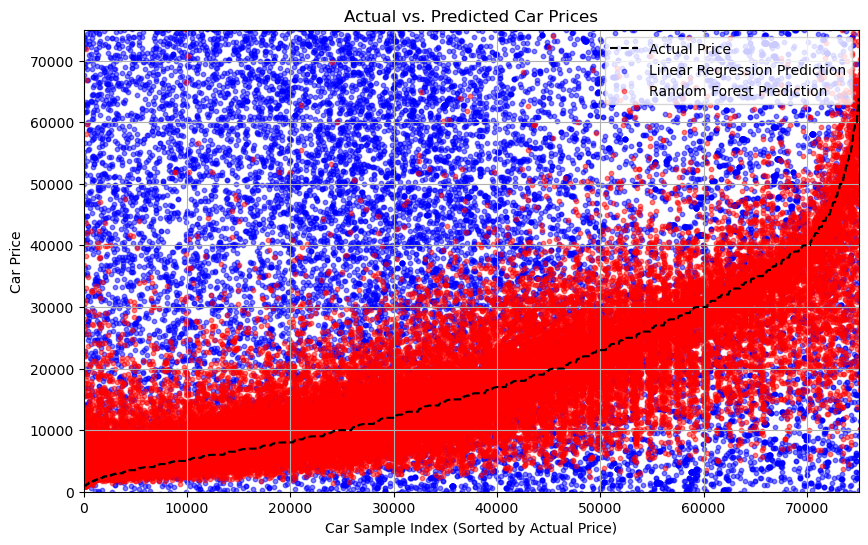

In [107]:
# Sorting for better visualization
sorted_idx = np.argsort(y_test)  # Sort indices based on actual price
y_test_sorted = y_test.iloc[sorted_idx]

y_pred_lr=lr_pipeline.predict(X_test)
y_pred_rf=rf_pipeline.predict(X_test)

y_pred_lr_sorted = y_pred_lr[sorted_idx]
y_pred_rf_sorted = y_pred_rf[sorted_idx]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(y_test_sorted.values, label='Actual Price', color='black', linestyle='dashed')
plt.scatter(range(len(y_pred_lr_sorted)), y_pred_lr_sorted, label='Linear Regression Prediction', color='blue', alpha=0.5, s=10)
plt.scatter(range(len(y_pred_rf_sorted)), y_pred_rf_sorted, label='Random Forest Prediction', color='red', alpha=0.5, s=10)

# Set x-axis and y-axis limits
plt.xlim(0, 75000)  # Limit x-axis to 75,000
plt.ylim(0, 75000)  # Limit y-axis to 75,000

# Labels & Legend
plt.xlabel("Car Sample Index (Sorted by Actual Price)")
plt.ylabel("Car Price")
plt.title("Actual vs. Predicted Car Prices")
plt.legend()
plt.grid(True)

# Show Plot
plt.show()

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

In [ ]:
1. In this analysis, we first conducted a correlation analysis and find out the import features and its values, to reduce the dummy columns from 27737 to 97 columns.
This is a key to reduce the model size so that much less memory is needed.

In [ ]:
2. I then use two regression models for the study, linear regression and Random Forest. It is apparently that the random forest prediction is much better.

In [ ]:
3. next step, I can dive into the model and carefully choose more related features for the analysis, and also optimize some of the model details, for a better predcition.